In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torchvision.transforms.v2 import ToImage, Resize, CenterCrop, Compose
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, StableUnCLIPImg2ImgPipeline

import sys
sys.path.append('./tva_calibration/')
from tva_calibration.evaluation import ECE_calc, metrics_from_logits_labels, eval_binary_method
from tva_calibration.tva_utils import logits_labels_from_dataloader, LogitsDataset
from tva_calibration.calibrators import fit_scaling_model, fit_binary_method, Temperature, Vector, Dirichlet

path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 
path_pretrained = Path(os.path.expandvars('$WORK/MODELS'))


In [2]:
class CLIP_ZeroShot(nn.Module):
    def __init__(self, list_prompts):
        super().__init__()
        self.CLIP_model = CLIPModel.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14").cuda()
        self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")
        self.list_prompts = list_prompts

    def forward(self, images):
        with torch.no_grad():
            inputs = self.CLIP_processor(text=self.list_prompts, images=images, return_tensors="pt", padding=True)
            for name, tensor in inputs.items():
                inputs[name] = tensor.cuda()
            outputs = self.CLIP_model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        # probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        return logits_per_image

class CUB(Dataset):
    """from https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py"""
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')
        self.targets = (self.data['target'] - 1).to_numpy()

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])
        self.class_names = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'classes.txt'), 
                                       usecols=[1], sep='.', header=None, dtype=str).iloc[:,0].str.replace('_', ' ').to_dict()

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


batch_size = 256

train_dataset = CUB(root=os.path.expandvars('$SCRATCH'), transform=Compose([ToImage(), Resize(224), CenterCrop(224)]), train=True)
test_dataset = CUB(root=os.path.expandvars('$SCRATCH'), transform=Compose([ToImage(), Resize(224), CenterCrop(224)]), train=False)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

clip = CLIP_ZeroShot([f"A photo of a {class_name}." for class_name in list(test_dataset.class_names.values())])

In [51]:
# Create calibration data
calib_size = 1000
_, calib_indices = train_test_split(np.arange(len(train_dataset)), train_size=len(train_dataset) - calib_size,
                                    stratify=train_dataset.targets, random_state=0)
calib_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(calib_indices))

logits_calib, labels_calib = logits_labels_from_dataloader(clip, calib_dataloader)
# logits_test, labels_test = logits_labels_from_dataloader(clip, test_dataloader)
dataset_logits_calib = LogitsDataset(logits_calib, labels_calib)
dataloader_logits_calib = DataLoader(dataset_logits_calib, batch_size=512)


In [52]:
num_epochs = 200
num_classes = 200

metrics_test_original = metrics_from_logits_labels(logits_test, labels_test)
df_results = pd.DataFrame([{'method': 'original', **metrics_test_original}])

scaling_methods = ['TS', 'TS_tva', 'VS', 'VS_reg', 'VS_tva', 'VS_reg_tva']
for method in scaling_methods:
    # fit parameters
    if method == 'TS':
        model = fit_scaling_model('temperature', dataloader_logits_calib, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    elif method == 'TS_tva':
        model = fit_scaling_model('temperature', dataloader_logits_calib, num_classes, binary_loss=True, regularization=False, num_epochs=num_epochs)
    elif method == 'VS':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    elif method == 'VS_reg':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=False, regularization=True, num_epochs=num_epochs)
    elif method == 'VS_tva':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=True, regularization=False, num_epochs=num_epochs)
    elif method == 'VS_reg_tva':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=True, regularization=True, num_epochs=num_epochs)
    
    # evaluate
    with torch.no_grad():
        logits_scaled = model(logits_test.cuda()).cpu()
    metrics_test = metrics_from_logits_labels(logits_scaled, labels_test)
    if 'TS' in method:
        metrics_test['temperature'] = model.temp.item()

    # save results
    df_results = pd.concat([df_results, pd.DataFrame([{'method': method, **metrics_test}])])


binary_methods = ['HB_eqsize', 'HB_eqmass', 'HB_tva_eqsize', 'HB_tva_eqmass', 'Iso', 'Iso_tva']
for method in binary_methods:
    # fit
    try:
        model = fit_binary_method(method, logits_calib, labels_calib, num_classes)
    except: pass

    # evaluate
    metrics_test = eval_binary_method(method, model, logits_test, labels_test)

    # save results
    df_results = pd.concat([df_results, pd.DataFrame([{'method': method, **metrics_test}])])


df_results

,method,ECE_15,AdaECE_15,Accuracy,Average_Confidence,AUROC,Brier_top,temperature
0,original,0.028725,0.029861,62.581980,0.649463,0.809843,0.171585,NaN
0,TS,0.035398,0.036394,62.581980,0.590422,0.807750,0.173017,1.190712
0,TS_tva,0.029691,0.030713,62.581980,0.596944,0.808108,0.172425,1.169300
0,VS,0.042615,0.041945,67.224717,0.630302,0.824969,0.159661,NaN
0,VS_reg,0.042619,0.041948,67.224717,0.630299,0.824977,0.159655,NaN
0,VS_tva,0.025580,0.023468,65.447015,0.659549,0.849784,0.150006,NaN
0,VS_reg_tva,0.024261,0.023220,65.481532,0.659408,0.849527,0.150077,NaN
0,HB_eqsize,0.104631,0.108999,60.234725,0.682184,0.813653,0.181077,NaN
0,HB_eqmass,0.104631,0.108999,60.234725,0.682184,0.813653,0.181077,NaN
0,HB_tva_eqsize,0.037970,0.042818,62.581981,0.636032,0.806214,0.173823,NaN


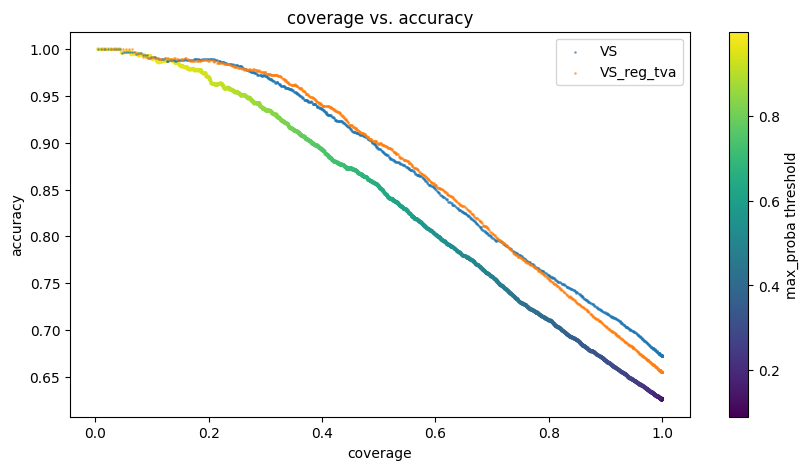

In [53]:
# baseline: max softmax
max_proba, pred = logits_test.softmax(1).max(1)
domain_cutoff_baseline = np.linspace(max_proba.min(), max_proba.max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = max_proba > cut
    coverage_baseline[i] = idx_domain.float().mean()
    acc_baseline[i] = (pred == labels_test)[idx_domain].float().mean()
# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='max_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')



scaling_methods = [
    # 'TS', 'TS_tva'
    'VS', 
    # 'VS_reg', 'VS_tva', 
    'VS_reg_tva'
    ]
for method in scaling_methods:
    # fit parameters
    if method == 'TS':
        model = fit_scaling_model('temperature', dataloader_logits_calib, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    elif method == 'TS_tva':
        model = fit_scaling_model('temperature', dataloader_logits_calib, num_classes, binary_loss=True, regularization=False, num_epochs=num_epochs)
    elif method == 'VS':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=False, regularization=False, num_epochs=num_epochs)
    elif method == 'VS_reg':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=False, regularization=True, num_epochs=num_epochs)
    elif method == 'VS_tva':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=True, regularization=False, num_epochs=num_epochs)
    elif method == 'VS_reg_tva':
        model = fit_scaling_model('vector', dataloader_logits_calib, num_classes, binary_loss=True, regularization=True, num_epochs=num_epochs)
    
    with torch.no_grad():
        logits_scaled = model(logits_test.cuda()).cpu()
    max_proba, pred = logits_scaled.softmax(1).max(1)
    domain_cutoff = np.linspace(max_proba.min(), max_proba.max(), 1000)
    coverage = np.zeros_like(domain_cutoff)
    risk = np.zeros_like(domain_cutoff)
    acc = np.zeros_like(domain_cutoff)
    for i, cut in enumerate(domain_cutoff):
        idx_domain = max_proba > cut
        coverage[i] = idx_domain.float().mean()
        acc[i] = (pred == labels_test)[idx_domain].float().mean()
    ax1.scatter(coverage, acc, s=1, label=method, alpha=0.5)
plt.legend()

# Linear probe:
## improvements with class weights from classes cosine sim?

In [5]:
# class CLIP_LinearProbe(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.CLIP_vision_model = CLIPVisionModel.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14").cuda()
#         self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")

#     def forward(self, images):
#         with torch.no_grad():
#             inputs = self.CLIP_processor(images=images, return_tensors="pt")
#             for name, tensor in inputs.items():
#                 inputs[name] = tensor.cuda()
#             outputs = self.CLIP_vision_model(**inputs).pooler_output
#         return outputs

In [6]:
# from torch.utils.data import random_split
# from sklearn.linear_model import LogisticRegression

# clip_lp = CLIP_LinearProbe()

# def get_features_labels(dataloader):
#     all_features = []
#     all_labels = []
#     for images, labels in dataloader:
#         out = clip_lp(images)
#         all_features.append(out.cpu())
#         all_labels.append(labels)
#     all_features = torch.cat(all_features).numpy()
#     all_labels = torch.cat(all_labels).numpy()
#     return all_features, all_labels

# frac = 0.05
# train_dataset_fraction, _ = random_split(train_dataset, [frac, 1-frac])

# train_features, train_labels = get_features_labels(DataLoader(train_dataset_fraction, batch_size=batch_size))
# test_features, test_labels = get_features_labels(test_dataloader)


# # Perform logistic regression
# classifier = LogisticRegression(random_state=0, C=1, max_iter=1000, verbose=1)
# classifier.fit(train_features, train_labels)

# # Evaluate using the logistic regression classifier
# predictions = classifier.predict(test_features)
# accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
# print(f"Accuracy = {accuracy:.3f}")

In [7]:
# # study text encoder
# with torch.no_grad():
#     inputs = clip.CLIP_processor(text=clip.list_prompts, return_tensors="pt", padding=True)
#     for name, tensor in inputs.items():
#         inputs[name] = tensor.cuda()
#     outputs = clip.CLIP_model.text_model(**inputs)
#     text_embeds = clip.CLIP_model.text_projection(outputs[1])
#     text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

#     text_cosim = torch.matmul(text_embeds, text_embeds.t())
# text_cosim = text_cosim.cpu()

# n_bins = 6
# variable = torch.topk(text_cosim.softmax(1), k=2, dim=1).values[:,1].numpy()
# bins = np.linspace(min(variable), max(variable), n_bins+1)
# binned_indices = np.digitize(variable, bins)
# bin_weights = {
#     1: 1.,
#     2: 1.2 ,
#     3: 1.4,
#     4: 1.6,
#     5: 1.8,
#     6: 2.,
#     7: 2.
# }
# class_weights = {k: 0. for k in range(200)}
# for i in range(200):
#     class_weights[i] = bin_weights[binned_indices[i]]


# # Perform logistic regression
# classifier = LogisticRegression(random_state=0, C=1, max_iter=1000, verbose=1, class_weight=class_weights)
# classifier.fit(train_features, train_labels)

# # Evaluate using the logistic regression classifier
# predictions = classifier.predict(test_features)
# accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
# print(f"Accuracy = {accuracy:.3f}")